**Fraud Detection with Neural Network**



# Neural Network for Fraud detection with SMOTE

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

In this notebook for handle the imbalanced data I have used the undersample technique. 

I have also writed another notebook where handle this situation using [SMOTE](https://www.kaggle.com/davidevegliante/nn-for-fraud-detection-with-smote) technique.

**These are my first two notebooks, I hope to receive comment and advice for improve the understanding of the tools I used. **





In [26]:
! pip show numpy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import os

# read the dataset and print five rows
original_dataset = pd.read_csv('./input/creditcard.csv')

dataset = original_dataset.copy()
print(dataset.head(5))


Name: numpy
Version: 1.18.4
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /home/angad/.local/lib/python3.8/site-packages
Requires: 
Required-by: tensorflow, tensorboard, scipy, scikit-learn, pandas, opt-einsum, matplotlib, Keras, Keras-Preprocessing, Keras-Applications, imbalanced-learn, h5py
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0

Let's see how many example in our dataset we have. 

284315 Non-fraud example
492 Fraud examples


Text(0.5, 1.0, 'Fraud Class Hist')

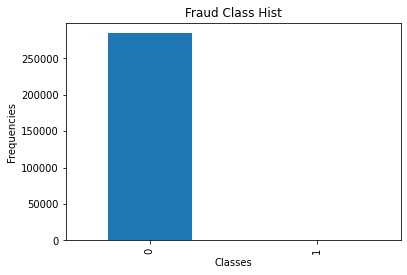

In [27]:
# count how many entry there are for every class
classes_count = pd.value_counts(dataset['Class'])

print("{} Non-fraud example\n{} Fraud examples".format(classes_count[0], classes_count[1]))

# classes_count is a Series. 
classes_count.plot(kind = 'bar')
plt.xlabel('Classes')
plt.ylabel('Frequencies')
plt.title('Fraud Class Hist')

The classes of the dataset are not represented equally. 

In [28]:
# scale the amount feature
from sklearn.preprocessing import StandardScaler
amount_scaler = StandardScaler().fit(dataset[['Amount']])
dataset['AmountScaled'] = amount_scaler.transform(dataset[['Amount']])

# remove the old Amount Feature
dataset.drop(['Time', 'Amount'], axis = 1, inplace = True)

dataset.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,AmountScaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


**  Undersampling with ratio 1**

In [29]:
X = dataset.loc[:, dataset.columns != 'Class' ]
y = dataset.loc[:, dataset.columns == 'Class' ]

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 0, sampling_strategy = 1.0)
X_resampled, y_resampled = rus.fit_resample(X, y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.20, stratify = y_resampled)

#assert len(y_train[y_train == 1]) + len(y_test[y_test == 1]) == len(dataset[dataset.Class == 1])
print("train_set size: {} - Class0: {}, Class1: {}".format( len(y_train), len(y_train[y_train == 0]), len(y_train[y_train == 1]) ))
print("test_set size: {} - Class0: {}, Class1: {}".format( len(y_test), len(y_test[y_test == 0]), len(y_test[y_test == 1]) ))


train_set size: 787 - Class0: 787, Class1: 787
test_set size: 197 - Class0: 197, Class1: 197


**NN Structure**


In [30]:
import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

# init ann
classifier = Sequential()

# in this case we used a rectifier activation function for the hidden layers
# and a sigmoid function for the output layer
classifier.add(Dense(
    input_dim = len(X.columns), # input neurons
    units = 15, # first hidden layer
    kernel_initializer = 'he_normal', 
    bias_initializer = 'zeros',
    activation = 'relu', # activation function (rectifier)
    kernel_regularizer=regularizers.l2(0.006)
))
# add a new hidden layer with the same number of neurons
classifier.add(Dense(
    units = 6, # second hidden layer
    kernel_initializer = 'he_normal',
    bias_initializer = 'zeros',
    activation = 'relu', # activation function (rectifier)
    kernel_regularizer=regularizers.l2(0.006)
))
# add the output layer with one neuron
classifier.add(Dense(
    units = 1, # output layer
    kernel_initializer = 'random_uniform',
    bias_initializer = 'zeros',
    activation = 'sigmoid', # activation function (sigmoid)
    kernel_regularizer=regularizers.l2(0.006)
))

# Compiling the ANN
classifier.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy', # cost function
    metrics = ['accuracy']
)

# fit the ann to the Training set
history = classifier.fit(
    X_train, y_train,  # training set
    validation_data = (X_test, y_test),
    batch_size = 40,
    epochs = 70,
    verbose = False
)


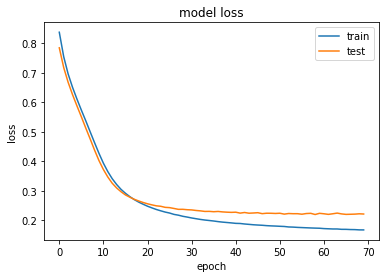

In [31]:
# summarize history for accuracy
"""
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
"""
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

[[95  4]
 [ 5 93]]


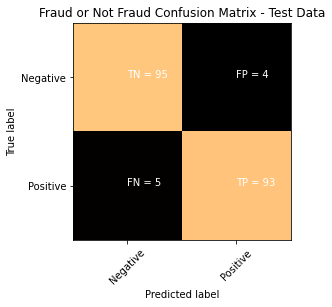

In [32]:

from sklearn.metrics import confusion_matrix
y_test_pred = classifier.predict(X_test) > 0.5
cm = confusion_matrix(y_test, y_test_pred)

#print('Train Accuracy: {}\nTest Accuracy:{}'.format(history.history['acc'][-1], history.history['val_acc'][-1]))
print(cm)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.copper)
classNames = ['Negative','Positive']
plt.title('Fraud or Not Fraud Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), color = 'white')
plt.show()


In [33]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_test_pred)

print("F1 Score: {}".format(f1))

F1 Score: 0.9538461538461539
